In [1]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Analysis
import os
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
#import regionmask
import pickle
import scipy.stats as stats
import glob
import Ngl
import Nio 
import metpy.calc as mpc
from metpy.units import units


In [4]:
''' 
Short function to wrap around Ngl.vinth2p and return things in useful xr.dataset format. 
'''
def interpolate_DSvar(DS,varName,pnew,pftFlag): 
    
    #Case where we don't have individual PFTs:
    # -----------------------------------------
    if pftFlag==0:

        varOrig = np.asarray(DS[varName].values)
        p0mb    = np.asarray(DS.P0.values)/100        # mb
        PS      = np.asarray(DS.PS.values)               # Pa 

        # Assuming by DEFAULT here that lev = 64 levels, ilev = 65 levels. 
        #    AND that data is ordered [time,lev]
        nlevs = np.shape(varOrig)[1]

        # Pull out hya/hyb profiles
        if nlevs==64: 
            hya = np.asarray(DS.hyam.values[:])
            hyb = np.asarray(DS.hybm.values[:])
        elif nlevs==65:
            hya = np.asarray(DS.hyai.values[:])
            hyb = np.asarray(DS.hybi.values[:])
        else: 
            print('!! Unrecognized number of levels !!')

        varInterp = Ngl.vinth2p(varOrig,hya,hyb,pnew,PS,1,p0mb,1,True)

        # Save interpolated values back into DS
        #interpDS = dFull['Plcl']  = (('time','lat','lon'), Plcl_sel)
        varInterpDS = xr.DataArray( data=np.squeeze(varInterp), 
                                    dims=["time","interpLevs"],
                                    coords=dict(time = (["time"], DS.time.values),
                                                interpLevs = (["interpLevs"], pnew)),
                              )

    # Case where we *do* have individual PFTs as a dimension 
    # -----------------------------------------
    elif pftFlag==1:
        varOrig_all = np.asarray(DS[varName].values)
        p0mb        = np.asarray(DS.P0.values)[0]/100        # mb
        
        nPFTs = np.shape(varOrig_all)[0]
        nlevs = np.shape(varOrig_all)[2]
        
        # Pull out hya/hyb profiles
        if nlevs==64: 
            hya = np.asarray(DS.hyam.values[0,:])
            hyb = np.asarray(DS.hybm.values[0,:])
        elif nlevs==65:
            hya = np.asarray(DS.hyai.values[0,:])
            hyb = np.asarray(DS.hybi.values[0,:])
        else: 
            print('!! Unrecognized number of levels !!')
        
        varInterp = np.full([nPFTs,np.shape(varOrig_all)[1],len(pnew)], np.nan)   #[PFT, time, lev]
        
        for iPft in range(nPFTs):
            varOrig = varOrig_all[iPft,:,:,:,:]
            PS      = np.asarray(DS.PS.values[iPft,:,:,:])

            varInterp[iPft,:,:] = np.squeeze(Ngl.vinth2p(varOrig,hya,hyb,pnew,PS,1,p0mb,1,True))
        
        
        varInterpDS = xr.DataArray( data=np.squeeze(varInterp), 
                                    dims=["sfcType","time","interpLevs"],
                                    coords=dict(sfcType = (["sfcType"],DS.sfcType.values),
                                                time = (["time"], DS.time.values),
                                                interpLevs = (["interpLevs"], pnew)),
                              )
        
    DS[varName+'_interp'] = varInterpDS
    
    return DS

## Read in data

In [151]:
# Read in 50/50 case (hmg)
dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/SingleLandType/zconst_32p5/V2_noSrfPropertiesPrescribed/'
camFile_HMG = dataDir+'FSCAM.T42_T42.arm97.clasp_Andre_Zconst32_noMoments-64lev_startDay0531.SrfMod-50urban50lake.cam.h0.2015-05-31-00000.nc'
clmFile_HMG = dataDir+'FSCAM.T42_T42.arm97.clasp_Andre_Zconst32_noMoments-64lev_startDay0531.SrfMod-50urban50lake.clm2.h0.2015-05-31-00000.nc'
clmFile_HMG_pfts = dataDir+'FSCAM.T42_T42.arm97.clasp_useAndre_Zconst32p5_srfFluxAvg1-64lev_startDay0531_ctsmHTG_50urban50lake-PFToutputAllVars.cam.h0.2015-05-31-00172.nc'

camFile_HTG = dataDir+'FSCAM.T42_T42.arm97.clasp_useAndre_Zconst32p5_srfFluxAvg1-64lev_startDay0531_ctsmHTG_50urban50lake.cam.h0.2015-05-31-00172.nc'
clmFile_HTG = dataDir+'FSCAM.T42_T42.arm97.clasp_useAndre_Zconst32p5_srfFluxAvg1-64lev_startDay0531_ctsmHTG_50urban50lake.clm2.h0.2015-05-31-00172.nc'
clmFile_HTG_pfts = dataDir+'FSCAM.T42_T42.arm97.clasp_useAndre_Zconst32p5_srfFluxAvg1-64lev_startDay0531_ctsmHTG_50urban50lake-PFToutputAllVars.clm2.h0.2015-05-31-00172.nc'

# ------------------------------------------------------------------------------------------

with xr.open_dataset(camFile_HMG, decode_times=True) as camDS_5050hmg:
    camDS_5050hmg['time']  = camDS_5050hmg.indexes['time'].to_datetimeindex()
    
    timesCLASP = pd.DatetimeIndex(camDS_5050hmg['time'].values)
    iTimeStart = np.where((timesCLASP.day==1) & (timesCLASP.hour==6))[0]
    camDS_5050hmg = camDS_5050hmg.isel(time=np.arange(iTimeStart[0],len(timesCLASP)))

with xr.open_dataset(clmFile_HMG, decode_times=True) as clmDS_5050hmg:
    clmDS_5050hmg['time']  = clmDS_5050hmg.indexes['time'].to_datetimeindex()
    
    timesCLASP = pd.DatetimeIndex(clmDS_5050hmg['time'].values)
    iTimeStart = np.where((timesCLASP.day==1) & (timesCLASP.hour==6))[0]
    clmDS_5050hmg = clmDS_5050hmg.isel(time=np.arange(iTimeStart[0],len(timesCLASP)))
    
with xr.open_dataset(clmFile_HMG_pfts, decode_times=True) as clmDS_5050hmg_pfts:
    clmDS_5050hmg_pfts['time']  = clmDS_5050hmg_pfts.indexes['time'].to_datetimeindex()
    
    timesCLASP = pd.DatetimeIndex(clmDS_5050hmg_pfts['time'].values)
    iTimeStart = np.where((timesCLASP.day==1) & (timesCLASP.hour==6))[0]
    clmDS_5050hmg_pfts = clmDS_5050hmg_pfts.isel(time=np.arange(iTimeStart[0],len(timesCLASP)))
    
# ------------------------------------------------------------------------------------------

with xr.open_dataset(camFile_HTG, decode_times=True) as camDS_5050htg:
    camDS_5050htg['time']  = camDS_5050htg.indexes['time'].to_datetimeindex()
    
    timesCLASP = pd.DatetimeIndex(camDS_5050htg['time'].values)
    iTimeStart = np.where((timesCLASP.day==1) & (timesCLASP.hour==6))[0]
    camDS_5050htg = camDS_5050htg.isel(time=np.arange(iTimeStart[0],len(timesCLASP)))

with xr.open_dataset(clmFile_HTG, decode_times=True) as clmDS_5050htg:
    clmDS_5050htg['time']  = clmDS_5050htg.indexes['time'].to_datetimeindex()
    
    timesCLASP = pd.DatetimeIndex(clmDS_5050htg['time'].values)
    iTimeStart = np.where((timesCLASP.day==1) & (timesCLASP.hour==6))[0]
    clmDS_5050htg = clmDS_5050htg.isel(time=np.arange(iTimeStart[0],len(timesCLASP)))
    
with xr.open_dataset(clmFile_HTG_pfts, decode_times=True) as clmDS_5050htg_pfts:
    clmDS_5050htg_pfts['time']  = clmDS_5050htg_pfts.indexes['time'].to_datetimeindex()
    
    timesCLASP = pd.DatetimeIndex(clmDS_5050htg_pfts['time'].values)
    iTimeStart = np.where((timesCLASP.day==1) & (timesCLASP.hour==6))[0]
    clmDS_5050htg_pfts = clmDS_5050htg_pfts.isel(time=np.arange(iTimeStart[0],len(timesCLASP)))

timesHTG = pd.DatetimeIndex(clmDS_5050htg['time'].values) 


<ipython-input-151-6eeff11d59f5>:14: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  camDS_5050hmg['time']  = camDS_5050hmg.indexes['time'].to_datetimeindex()
<ipython-input-151-6eeff11d59f5>:21: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  clmDS_5050hmg['time']  = clmDS_5050hmg.indexes['time'].to_datetimeindex()
<ipython-input-151-6eeff11d59f5>:28: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depe

**Handle the vector format of PFT-specific outputs**

In [152]:
# Get indices of which PFTs are lake vs. urban
iPFT_lake  = np.where(clmDS_5050htg_pfts.cols1d_itype_col==5)[0]
iPFT_urban = np.where(clmDS_5050htg_pfts.cols1d_itype_col>=70)[0]

zeta_htg_urbanALL = clmDS_5050htg_pfts.ZETA.values[:,iPFT_urban]
zeta_htg_urban = np.average(zeta_htg_urbanALL, axis=1, weights=clmDS_5050htg_pfts.pfts1d_wtgcell[iPFT_urban])
zeta_htg_lake  = clmDS_5050htg_pfts.ZETA.values[:,iPFT_lake]

ustar_htg_urbanALL = clmDS_5050htg_pfts.USTAR.values[:,iPFT_urban]
ustar_htg_urban = np.average(ustar_htg_urbanALL, axis=1, weights=clmDS_5050htg_pfts.pfts1d_wtgcell[iPFT_urban])
ustar_htg_lake  = clmDS_5050htg_pfts.USTAR.values[:,iPFT_lake]


In [161]:
lake_clmDS  = clmDS_5050htg_pfts.isel(pft=iPFT_lake)
urban_clmDS = clmDS_5050htg_pfts.isel(pft=iPFT_urban)


**Read in cases with just a single surface type**

In [64]:
# Read in individual surface information

# Modification 2: z_const = 32.5m, and scm_iop_land_srf = .false.
dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/SingleLandType/zconst_32p5/V2_noSrfPropertiesPrescribed/'
fileStart = 'FSCAM.T42_T42.arm97.clasp_Andre_Zconst32_noMoments-64lev_startDay0531.SrfMod-'
sfcTypes = np.asarray(['HighDensityUrban', 'Lake'])

camEnd    = '.cam.h0.2015-05-31-00000.nc'
clmEnd    = '.clm2.h0.2015-05-31-00000.nc'


for iSfc in range(len(sfcTypes)):
    fileName_CAM = dataDir+fileStart+sfcTypes[iSfc]+camEnd
    fileName_CLM = dataDir+fileStart+sfcTypes[iSfc]+clmEnd

    # Add a "sfcType" dimension so that all 9 types can be read in
    with xr.open_dataset(fileName_CAM, decode_times=True) as camDS:
        camDS = camDS.expand_dims({"sfcType": 1})
        
        camDS['time']  = camDS.indexes['time'].to_datetimeindex()
        timesCLASP = pd.DatetimeIndex(camDS['time'].values)
        iTimeStart = np.where((timesCLASP.day==1) & (timesCLASP.hour==6))[0]
        camDS = camDS.isel(time=np.arange(iTimeStart[0],len(timesCLASP)))
    
    with xr.open_dataset(fileName_CLM, decode_times=True) as clmDS:
        clmDS = clmDS.expand_dims({"sfcType": 1})
        
        clmDS['time']  = clmDS.indexes['time'].to_datetimeindex()
        timesCLASP = pd.DatetimeIndex(clmDS['time'].values)
        iTimeStart = np.where((timesCLASP.day==1) & (timesCLASP.hour==6))[0]
        clmDS = clmDS.isel(time=np.arange(iTimeStart[0],len(timesCLASP)))
    
    # Concatenate all those different surface type runs into a single xr dataset:
    if iSfc==0:
        camDS_indivdSfc5050 = camDS
        clmDS_indivdSfc5050 = clmDS
    else:
        camDS_indivdSfc5050 = xr.concat([camDS_indivdSfc5050, camDS], "sfcType")
        clmDS_indivdSfc5050 = xr.concat([clmDS_indivdSfc5050, clmDS], "sfcType")

# Fill out sfcType dimension with useful names 
camDS_indivdSfc5050['sfcType'] = sfcTypes
clmDS_indivdSfc5050['sfcType'] = sfcTypes


## Add a weights variable to xr datasets:
## ----------------------------------------

sfcTypeWeights = np.full([len(camDS_indivdSfc5050.sfcType)], np.nan)

# High density urban: 
sfcTypeWeights[np.where(camDS_indivdSfc5050.sfcType=='HighDensityUrban')[0]] = 50.0

# Lake: 
sfcTypeWeights[np.where(camDS_indivdSfc5050.sfcType=='Lake')[0]] = 50.0


<ipython-input-64-02e5bf1d32a6>:20: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  camDS['time']  = camDS.indexes['time'].to_datetimeindex()
<ipython-input-64-02e5bf1d32a6>:28: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  clmDS['time']  = clmDS.indexes['time'].to_datetimeindex()
<ipython-input-64-02e5bf1d32a6>:20: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between da

In [65]:
## Limit analysis to throw away the first day (spin up) 
times      = pd.DatetimeIndex(camDS_indivdSfc5050['time'].values,tz='UTC')
iTimeStart = np.where((times.day==1) & (times.hour==6))[0]

camDS_full = camDS_indivdSfc5050.isel(time=np.arange(iTimeStart[0],len(times)))
clmDS_full = clmDS_indivdSfc5050.isel(time=np.arange(iTimeStart[0],len(times)))

times      = times[iTimeStart[0]::] 


In [190]:
## First, just average using weights, don't worry about CLASP approach for incorporating heterogeneity 
## ----------------------------------------------------------------------------------------------------

#     The approach of ds.mean() doesn't quite work by default because some datatypes in camDS_full aren't 
#     capable of being averaged (i.e., strings and such). So I've created a subset of data that is likely of 
#     interest in camDS_keepVars. Just add any variables that are missing to that in the future.
 
camDS_indivdSfc5050_keepVars = camDS_indivdSfc5050[['SHFLX','LHFLX','PS','TS','TREFHT','RHREFHT','QREFHT','PBLH','P0','hyam','hybm','hyai','hybi',
                             'CDNUMC','CLDBOT','CLDHGH','CLDICE','CLDLIQ','CLDLOW','CLDMED','CLDTOP','CLDTOT',
                             'CLOUD','CLOUDCOVER_CLUBB','CLOUDFRAC_CLUBB','CONCLD','DTCOND','FLDS','FLNS','FLNT',
                              'FLUT','FSDS','FSNS','GCLDLWP','OMEGA','PRECC','PRECL','PRECSC','PRECSL','PRECT',
                              'PRECZ','Q','QFLX','RCMINLAYER_CLUBB','RCMTEND_CLUBB','RELHUM','RHO_CLUBB',
                              'RIMTEND_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','RVMTEND_CLUBB','STEND_CLUBB','SWCF',
                              'T','TAUX','TAUY','TGCLDCWP','TGCLDIWP','TGCLDLWP','THETAL','THLP2_CLUBB','TMQ',
                              'TS','U10','U','V','UP2_CLUBB','UPWP_CLUBB','UTEND_CLUBB','USTAR','VP2_CLUBB',
                              'VPWP_CLUBB','VTEND_CLUBB','WP2RTP_CLUBB','WP2THLP_CLUBB','WP2_CLUBB','WP3_CLUBB',
                              'WP4_CLUBB','WPRCP_CLUBB','WPRTP2_CLUBB','WPRTPTHLP_CLUBB','WPRTP_CLUBB',
                              'WPTHLP2_CLUBB','WPTHLP_CLUBB','Z3']]

camDS_indivdSfc5050_fullWeighted = camDS_indivdSfc5050_keepVars.weighted(xr.DataArray(sfcTypeWeights, dims={"sfcType": sfcTypes}))
camDS_indivdSfc5050_fullWeighted = camDS_indivdSfc5050_fullWeighted.mean(dim="sfcType")

# Do the same for CLM dataset...
clmDS_indivdSfc5050_keepVars = clmDS_indivdSfc5050[['DSL','FSH','EFLX_LH_TOT','FCEV','FCOV','FCTR','FGEV','FGR','FIRA','FIRE','FLDS','FSDS',
                             'FSR','H2OCAN','H2OSFC','H2OSOI','PBOT','PCT_CFT','PCT_LANDUNIT','PCT_NAT_PFT',
                             'QBOT','Q2M','QCHARGE','QDRAI','QINFL','QINTR','QOVER','QP2_CLUBB','QRUNOFF',
                             'QSOIL','QVEGE','QVEGT','RAIN','RH2M','SOILLIQ','SOILWATER_10CM','TAUX','TAUY','TBOT',
                             'THLP2_CLUBB','THLPQP_CLUBB','TSA','UP2_CLUBB','USTAR','WP2QP_CLUBB','WP2THLP_CLUBB',
                             'WP2_CLUBB','WP3_CLUBB','WP4_CLUBB','WPQP2_CLUBB','WPQP_CLUBB','WPTHLP2_CLUBB',
                             'WPTHLPQP_CLUBB','WPTHLP_CLUBB','ZBOT','ZETA']]

clmDS_indivdSfc5050_fullWeighted = clmDS_indivdSfc5050_keepVars.weighted(xr.DataArray(sfcTypeWeights, dims={"sfcType": sfcTypes}))
clmDS_indivdSfc5050_fullWeighted = clmDS_indivdSfc5050_fullWeighted.mean(dim="sfcType")


## Maybe don't interpolate... 
I'd done this to make sure everythings on the same level and so that we can look at everything equally in the vertical. But if we do just use the *surface*, are things similar?? 

In [229]:
# Add calculation of sfc virtual potential temperature per PFT, rather than using THETAL as output....
qrefht = camDS_indivdSfc5050_keepVars.QREFHT.values
trefht = camDS_indivdSfc5050_keepVars.TREFHT.values
PS     = camDS_indivdSfc5050_keepVars.PS.values

theta = trefht*(100000.0/PS)**0.286
Tv    = (1.0 + (0.61*qrefht))*theta

Tv_grid = np.average(Tv, axis=0, weights=sfcTypeWeights)

In [230]:
## Add in that heterogeneous term to each of the moments we care about...
## --------------------------------------------------------------------------

patchThetaDiff_sfc5050 = np.full([len(sfcTypes), len(camDS_indivdSfc5050_keepVars.time.values)], np.nan)
patchQdiff_sfc5050     = np.full([len(sfcTypes), len(camDS_indivdSfc5050_keepVars.time.values)], np.nan)

for iSfc in range(len(sfcTypes)):
    patchThetaDiff_sfc5050[iSfc,:] =  np.squeeze(Tv)[iSfc,:]     - np.squeeze(Tv_grid)
    patchQdiff_sfc5050[iSfc,:]     =  np.squeeze(qrefht)[iSfc,:] - np.squeeze(camDS_indivdSfc5050_fullWeighted.QREFHT.values)
    
# Define empty arrays for HTG versions of moments 
thlp2_sfc5050_withHTG   = np.full([len(camDS_indivdSfc5050_keepVars.time.values)], np.nan)
rtp2_sfc5050_withHTG    = np.full([len(camDS_indivdSfc5050_keepVars.time.values)], np.nan)
thlpRtp_sfc5050_withHTG = np.full([len(camDS_indivdSfc5050_keepVars.time.values)], np.nan)

for iTime in range(len(newDS_indivdSfc5050_keepVars.time.values)):
#     patchThetaDiffSqr_wgt = sfcTypeWeights * (patchThetaDiff_sfc5050[:,iTime]**2.0)
#     patchRtDiffSqr_wgt    = sfcTypeWeights * (patchQdiff_sfc5050[:,iTime]**2.0)
#     patchThlRt_wgt        = sfcTypeWeights * (patchThetaDiff_sfc5050[:,iTime]*patchQdiff_sfc5050[:,iTime])

    patchThetaDiffSqr_wgt = np.average(patchThetaDiff_sfc5050[:,iTime]**2.0, axis=0, weights=sfcTypeWeights)
    patchRtDiffSqr_wgt    = np.average((patchQdiff_sfc5050[:,iTime]*1000.0)**2.0, axis=0, weights=sfcTypeWeights)  #Convert qdiff from kg/kg to g/kg
    patchThlRt_wgt        = np.average(patchThetaDiff_sfc5050[:,iTime]*(patchQdiff_sfc5050[:,iTime]*1000.0), axis=0, weights=sfcTypeWeights)
    
#     thlp2_sfc5050_withHTG[iTime]   = np.squeeze(camDS_indivdSfc5050_fullWeighted.THLP2_CLUBB.values)[iTime,-1]   + (np.nansum(patchThetaDiffSqr_wgt)/np.nansum(sfcTypeWeights))
    thlp2_sfc5050_withHTG[iTime]   = np.squeeze(camDS_indivdSfc5050_fullWeighted.THLP2_CLUBB.values)[iTime,-1]   + patchThetaDiffSqr_wgt
    rtp2_sfc5050_withHTG[iTime]    = np.squeeze(camDS_indivdSfc5050_fullWeighted.RTP2_CLUBB.values)[iTime,-1]    + patchRtDiffSqr_wgt
    thlpRtp_sfc5050_withHTG[iTime] = np.squeeze(camDS_indivdSfc5050_fullWeighted.RTPTHLP_CLUBB.values)[iTime,-1] + patchThlRt_wgt
        
        

In [219]:
## Are the units on rtp2_clubb right?!
camDS_indivdSfc5050_keepVars.RTP2_CLUBB.units



'g^2/kg^2'

In [221]:
camDS_indivdSfc5050_keepVars.QREFHT.units

'kg/kg'

In [222]:
camDS_indivdSfc5050_keepVars.RTPTHLP_CLUBB.units

'K g/kg'

### Make some plots!

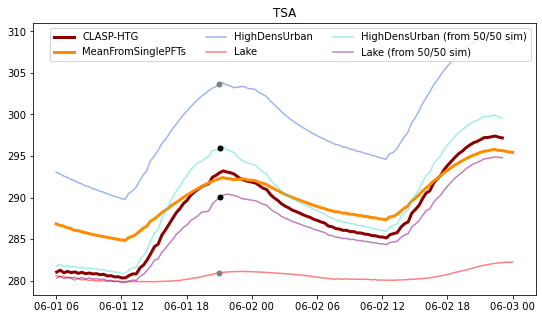

In [206]:
fig, axs0 = plt.subplots(1,1, figsize=(9, 5))

axs0.plot(timesHTG, np.squeeze(clmDS_5050htg.TSA.values),color='darkred',linewidth=3, label='CLASP-HTG')
axs0.plot(times, np.squeeze(clmDS_indivdSfc5050_fullWeighted.TSA.values),color='darkorange',linewidth=3, label='MeanFromSinglePFTs')

axs0.plot(times, np.squeeze(clmDS_indivdSfc5050_keepVars.TSA.values)[0,:],color='royalblue', label='HighDensUrban',alpha=0.5)
axs0.plot(times, np.squeeze(clmDS_indivdSfc5050_keepVars.TSA.values)[1,:],'r', label='Lake',alpha=0.5)

urbanMean_TSA = np.average(urban_clmDS.TSA.values, axis=1, weights=clmDS_5050htg_pfts.pfts1d_wtgcell[iPFT_urban])
axs0.plot(timesHTG, np.squeeze(urbanMean_TSA),color='turquoise', label='HighDensUrban (from 50/50 sim)',alpha=0.5)
axs0.plot(timesHTG, np.squeeze(lake_clmDS.TSA.values),color='purple', label='Lake (from 50/50 sim)',alpha=0.5)

axs0.legend(ncol=3)

axs0.set_title('TSA')

axs0.plot(timesHTG[45], np.squeeze(urbanMean_TSA)[45],'k.',markersize=10)
axs0.plot(timesHTG[45], np.squeeze(lake_clmDS.TSA.values)[45],'k.',markersize=10)

axs0.plot(times[45], np.squeeze(clmDS_indivdSfc5050_keepVars.TSA.values)[0,45],'.',color='grey',markersize=10)
axs0.plot(times[45], np.squeeze(clmDS_indivdSfc5050_keepVars.TSA.values)[1,45],'.',color='grey',markersize=10)


Text(0.5, 1.0, 'THLP2_CLUBB')

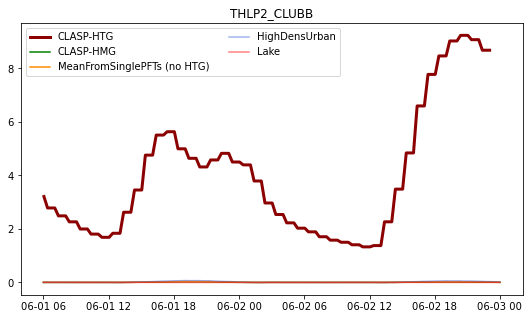

In [218]:
fig, axs0 = plt.subplots(1,1, figsize=(9, 5))

axs0.plot(timesHTG, np.squeeze(camDS_5050htg.THLP2_CLUBB.values)[:,-1],color='darkred',linewidth=3, label='CLASP-HTG')
axs0.plot(times, np.squeeze(camDS_5050hmg.THLP2_CLUBB.values)[:,-1],color='green', label='CLASP-HMG')
axs0.plot(times, np.squeeze(camDS_indivdSfc5050_fullWeighted.THLP2_CLUBB.values)[:,-1],color='darkorange',linewidth=3, label='MeanFromSinglePFTs (no HTG)')

axs0.plot(times, np.squeeze(camDS_indivdSfc5050_keepVars.THLP2_CLUBB.values)[0,:,-1],color='royalblue', label='HighDensUrban',alpha=0.5)
axs0.plot(times, np.squeeze(camDS_indivdSfc5050_keepVars.THLP2_CLUBB.values)[1,:,-1],'r', label='Lake',alpha=0.5)
axs0.legend(ncol=2)

axs0.set_title('THLP2_CLUBB')




Text(0.5, 1.0, 'THLP2_CLUBB')

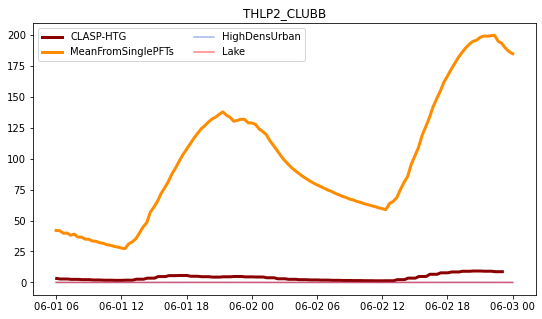

In [231]:
fig, axs0 = plt.subplots(1,1, figsize=(9, 5))

axs0.plot(timesHTG, np.squeeze(camDS_5050htg.THLP2_CLUBB.values)[:,-1],color='darkred',linewidth=3, label='CLASP-HTG')
# axs0.plot(times, np.squeeze(camDS_5050hmg.THLP2_CLUBB.values), label='CLASP-HMG')
axs0.plot(times, np.squeeze(thlp2_sfc5050_withHTG)[:],color='darkorange',linewidth=3, label='MeanFromSinglePFTs')

axs0.plot(times, np.squeeze(camDS_indivdSfc5050_keepVars.THLP2_CLUBB.values)[0,:,-1],color='royalblue', label='HighDensUrban',alpha=0.5)
axs0.plot(times, np.squeeze(camDS_indivdSfc5050_keepVars.THLP2_CLUBB.values)[1,:,-1],'r', label='Lake',alpha=0.5)
axs0.legend(ncol=2)

axs0.set_title('THLP2_CLUBB')



Text(0.5, 1.0, 'RTP2_CLUBB')

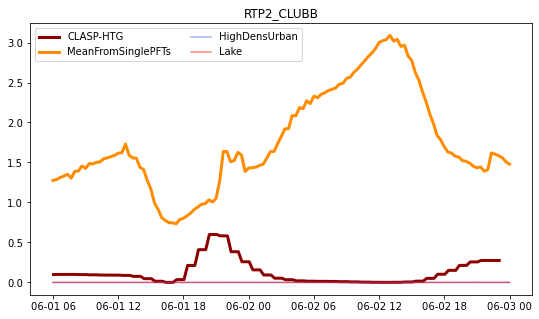

In [244]:
fig, axs0 = plt.subplots(1,1, figsize=(9, 5))

axs0.plot(timesHTG, np.squeeze(camDS_5050htg.RTP2_CLUBB.values)[:,-1],color='darkred',linewidth=3, label='CLASP-HTG')
# axs0.plot(times, np.squeeze(camDS_5050hmg.RTP2_CLUBB.values), label='CLASP-HMG')
# axs0.plot(times, np.squeeze(camDS_indivdSfc5050_fullWeighted.RTP2_CLUBB.values)[:,-1],color='darkorange',linewidth=3, label='MeanFromSinglePFTs (no HTG)')
axs0.plot(times, np.squeeze(rtp2_sfc5050_withHTG)[:],color='darkorange',linewidth=3, label='MeanFromSinglePFTs')

axs0.plot(times, np.squeeze(camDS_indivdSfc5050_keepVars.RTP2_CLUBB.values)[0,:,-1],color='royalblue', label='HighDensUrban',alpha=0.5)
axs0.plot(times, np.squeeze(camDS_indivdSfc5050_keepVars.RTP2_CLUBB.values)[1,:,-1],'r', label='Lake',alpha=0.5)
axs0.legend(ncol=2, loc='upper left')

axs0.set_title('RTP2_CLUBB')




Text(0.5, 1.0, 'RTPTHLP_CLUBB')

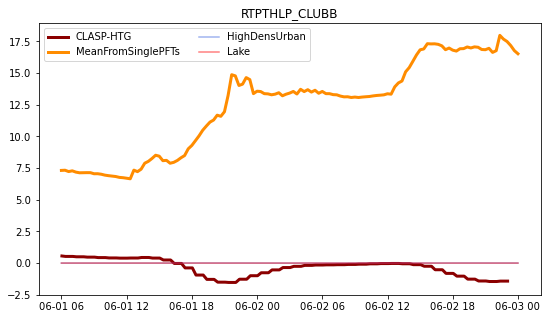

In [235]:
fig, axs0 = plt.subplots(1,1, figsize=(9, 5))

axs0.plot(timesHTG, np.squeeze(camDS_5050htg.RTPTHLP_CLUBB.values)[:,-1],color='darkred',linewidth=3, label='CLASP-HTG')
# axs0.plot(times, np.squeeze(camDS_5050hmg.RTP2_CLUBB.values), label='CLASP-HMG')
axs0.plot(times, np.squeeze(thlpRtp_sfc5050_withHTG)[:],color='darkorange',linewidth=3, label='MeanFromSinglePFTs')

axs0.plot(times, np.squeeze(camDS_indivdSfc5050_keepVars.RTPTHLP_CLUBB.values)[0,:,-1],color='royalblue', label='HighDensUrban',alpha=0.5)
axs0.plot(times, np.squeeze(camDS_indivdSfc5050_keepVars.RTPTHLP_CLUBB.values)[1,:,-1],'r', label='Lake',alpha=0.5)
axs0.legend(ncol=2)

axs0.set_title('RTPTHLP_CLUBB')



Text(0.5, 1.0, 'FSH')

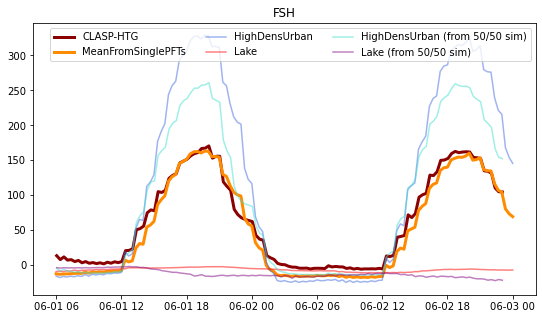

In [204]:
fig, axs0 = plt.subplots(1,1, figsize=(9, 5))

axs0.plot(timesHTG, np.squeeze(clmDS_5050htg.FSH.values),color='darkred',linewidth=3, label='CLASP-HTG')
axs0.plot(times, np.squeeze(clmDS_indivdSfc5050_fullWeighted.FSH.values),color='darkorange',linewidth=3, label='MeanFromSinglePFTs')

axs0.plot(times, np.squeeze(clmDS_indivdSfc5050_keepVars.FSH.values)[0,:],color='royalblue', label='HighDensUrban',alpha=0.5)
axs0.plot(times, np.squeeze(clmDS_indivdSfc5050_keepVars.FSH.values)[1,:],'r', label='Lake',alpha=0.5)

urbanMean_FSH = np.average(urban_clmDS.FSH.values, axis=1, weights=clmDS_5050htg_pfts.pfts1d_wtgcell[iPFT_urban])
axs0.plot(timesHTG, np.squeeze(urbanMean_FSH),color='turquoise', label='HighDensUrban (from 50/50 sim)',alpha=0.5)
axs0.plot(timesHTG, np.squeeze(lake_clmDS.FSH.values),color='purple', label='Lake (from 50/50 sim)',alpha=0.5)

axs0.legend(ncol=3)

axs0.set_title('FSH')


Text(0.5, 1.0, 'Q2M')

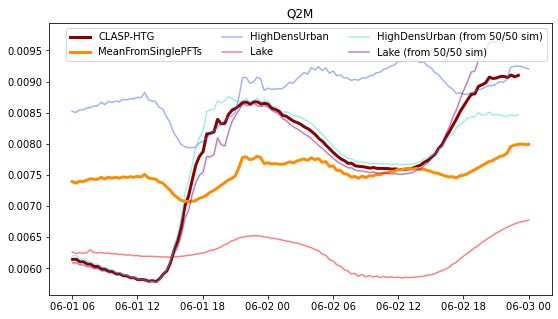

In [247]:
fig, axs0 = plt.subplots(1,1, figsize=(9, 5))

axs0.plot(timesHTG, np.squeeze(clmDS_5050htg.Q2M.values),color='darkred',linewidth=3, label='CLASP-HTG')
axs0.plot(times, np.squeeze(clmDS_indivdSfc5050_fullWeighted.Q2M.values),color='darkorange',linewidth=3, label='MeanFromSinglePFTs')

axs0.plot(times, np.squeeze(clmDS_indivdSfc5050_keepVars.Q2M.values)[0,:],color='royalblue', label='HighDensUrban',alpha=0.5)
axs0.plot(times, np.squeeze(clmDS_indivdSfc5050_keepVars.Q2M.values)[1,:],'r', label='Lake',alpha=0.5)

urbanMean_Q2M = np.average(urban_clmDS.Q2M.values, axis=1, weights=clmDS_5050htg_pfts.pfts1d_wtgcell[iPFT_urban])
axs0.plot(timesHTG, np.squeeze(urbanMean_Q2M),color='turquoise', label='HighDensUrban (from 50/50 sim)',alpha=0.5)
axs0.plot(timesHTG, np.squeeze(lake_clmDS.Q2M.values),color='purple', label='Lake (from 50/50 sim)',alpha=0.5)

axs0.legend(ncol=3)

axs0.set_title('Q2M')



Text(0.5, 1.0, 'RH2M')

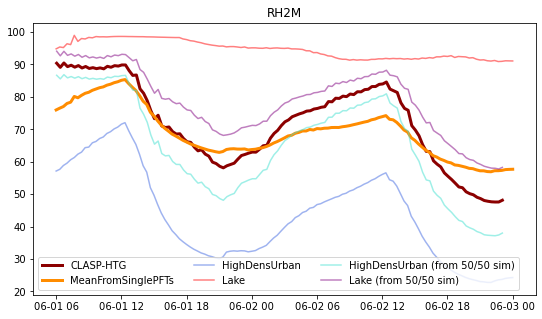

In [245]:
fig, axs0 = plt.subplots(1,1, figsize=(9, 5))

axs0.plot(timesHTG, np.squeeze(clmDS_5050htg.RH2M.values),color='darkred',linewidth=3, label='CLASP-HTG')
axs0.plot(times, np.squeeze(clmDS_indivdSfc5050_fullWeighted.RH2M.values),color='darkorange',linewidth=3, label='MeanFromSinglePFTs')

axs0.plot(times, np.squeeze(clmDS_indivdSfc5050_keepVars.RH2M.values)[0,:],color='royalblue', label='HighDensUrban',alpha=0.5)
axs0.plot(times, np.squeeze(clmDS_indivdSfc5050_keepVars.RH2M.values)[1,:],'r', label='Lake',alpha=0.5)

urbanMean_RH2M = np.average(urban_clmDS.RH2M.values, axis=1, weights=clmDS_5050htg_pfts.pfts1d_wtgcell[iPFT_urban])
axs0.plot(timesHTG, np.squeeze(urbanMean_RH2M),color='turquoise', label='HighDensUrban (from 50/50 sim)',alpha=0.5)
axs0.plot(timesHTG, np.squeeze(lake_clmDS.RH2M.values),color='purple', label='Lake (from 50/50 sim)',alpha=0.5)

axs0.legend(ncol=3)

axs0.set_title('RH2M')




Text(0.5, 1.0, 'EFLX_LH_TOT')

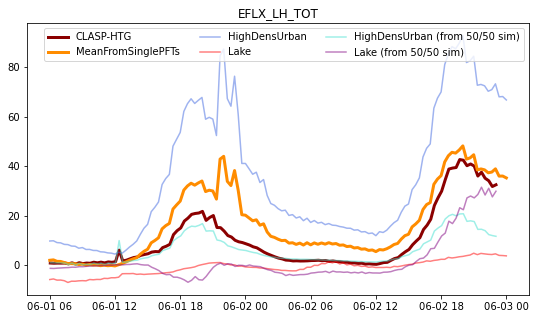

In [202]:
fig, axs0 = plt.subplots(1,1, figsize=(9, 5))

axs0.plot(timesHTG, np.squeeze(clmDS_5050htg.EFLX_LH_TOT.values),color='darkred',linewidth=3, label='CLASP-HTG')
axs0.plot(times, np.squeeze(clmDS_indivdSfc5050_fullWeighted.EFLX_LH_TOT.values),color='darkorange',linewidth=3, label='MeanFromSinglePFTs')

axs0.plot(times, np.squeeze(clmDS_indivdSfc5050_keepVars.EFLX_LH_TOT.values)[0,:],color='royalblue', label='HighDensUrban',alpha=0.5)
axs0.plot(times, np.squeeze(clmDS_indivdSfc5050_keepVars.EFLX_LH_TOT.values)[1,:],'r', label='Lake',alpha=0.5)

urbanMean_EFLX_LH_TOT = np.average(urban_clmDS.EFLX_LH_TOT.values, axis=1, weights=clmDS_5050htg_pfts.pfts1d_wtgcell[iPFT_urban])
axs0.plot(timesHTG, np.squeeze(urbanMean_EFLX_LH_TOT),color='turquoise', label='HighDensUrban (from 50/50 sim)',alpha=0.5)
axs0.plot(timesHTG, np.squeeze(lake_clmDS.EFLX_LH_TOT.values),color='purple', label='Lake (from 50/50 sim)',alpha=0.5)

axs0.legend(ncol=3)

axs0.set_title('EFLX_LH_TOT')




Text(0.5, 1.0, 'ZETA')

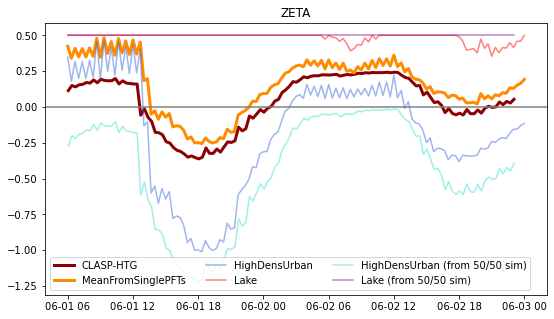

In [201]:
fig, axs0 = plt.subplots(1,1, figsize=(9, 5))

axs0.plot(timesHTG, np.squeeze(clmDS_5050htg.ZETA.values),color='darkred',linewidth=3, label='CLASP-HTG')
axs0.plot(times, np.squeeze(clmDS_indivdSfc5050_fullWeighted.ZETA.values),color='darkorange',linewidth=3, label='MeanFromSinglePFTs')

axs0.plot(times, np.squeeze(clmDS_indivdSfc5050_keepVars.ZETA.values)[0,:],color='royalblue', label='HighDensUrban',alpha=0.5)
axs0.plot(times, np.squeeze(clmDS_indivdSfc5050_keepVars.ZETA.values)[1,:],'r', label='Lake',alpha=0.5)

urbanMean_ZETA = np.average(urban_clmDS.ZETA.values, axis=1, weights=clmDS_5050htg_pfts.pfts1d_wtgcell[iPFT_urban])
axs0.plot(timesHTG, np.squeeze(urbanMean_ZETA),color='turquoise', label='HighDensUrban (from 50/50 sim)',alpha=0.5)
axs0.plot(timesHTG, np.squeeze(lake_clmDS.ZETA.values),color='purple', label='Lake (from 50/50 sim)',alpha=0.5)

axs0.legend(ncol=3)

axs0.axhline(0,color='grey')
axs0.set_title('ZETA')





Text(0.5, 1.0, 'USTAR')

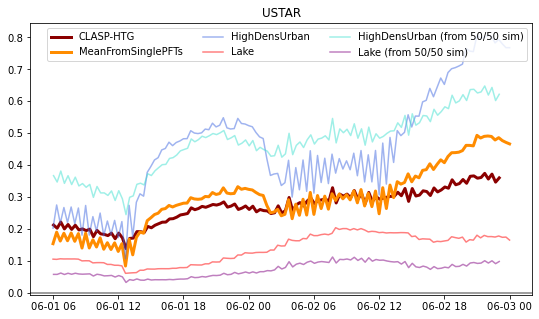

In [200]:
fig, axs0 = plt.subplots(1,1, figsize=(9, 5))

axs0.plot(timesHTG, np.squeeze(clmDS_5050htg.USTAR.values),color='darkred',linewidth=3, label='CLASP-HTG')
axs0.plot(times, np.squeeze(clmDS_indivdSfc5050_fullWeighted.USTAR.values),color='darkorange',linewidth=3, label='MeanFromSinglePFTs')

axs0.plot(times, np.squeeze(clmDS_indivdSfc5050_keepVars.USTAR.values)[0,:],color='royalblue', label='HighDensUrban',alpha=0.5)
axs0.plot(times, np.squeeze(clmDS_indivdSfc5050_keepVars.USTAR.values)[1,:],'r', label='Lake',alpha=0.5)

urbanMean_USTAR = np.average(urban_clmDS.USTAR.values, axis=1, weights=clmDS_5050htg_pfts.pfts1d_wtgcell[iPFT_urban])
axs0.plot(timesHTG, np.squeeze(urbanMean_USTAR),color='turquoise', label='HighDensUrban (from 50/50 sim)',alpha=0.5)
axs0.plot(timesHTG, np.squeeze(lake_clmDS.USTAR.values),color='purple', label='Lake (from 50/50 sim)',alpha=0.5)

axs0.legend(ncol=3)

axs0.axhline(0,color='grey')
axs0.set_title('USTAR')






In [187]:
lake_clmDS

<xarray.Dataset>
Dimensions:                        (cft: 2, column: 7, glc_nec: 10, gridcell: 1, hist_interval: 2, landunit: 3, lat: 1, levdcmp: 1, levgrnd: 25, levlak: 10, levsoi: 20, lon: 1, ltype: 9, natpft: 15, nvegwcs: 4, pft: 1, time: 124)
Coordinates:
  * levgrnd                        (levgrnd) float32 0.01 0.04 ... 28.87 42.0
  * levlak                         (levlak) float32 0.05 0.6 2.1 ... 34.33 44.78
  * levdcmp                        (levdcmp) float32 1.0
  * time                           (time) datetime64[ns] 2015-06-01T06:02:52 ...
  * lon                            (lon) float32 261.6
  * lat                            (lat) float32 37.67
Dimensions without coordinates: cft, column, glc_nec, gridcell, hist_interval, landunit, levsoi, ltype, natpft, nvegwcs, pft
Data variables:
    mcdate                         (time) int32 20150601 20150601 ... 20150602
    mcsec                          (time) int32 21772 22972 ... 81772 82972
    mdcur                          (time) int32 1 1 1 1 1 1 1 ... 2 2 2 2 2 2 2
    mscur                          (time) int32 21600 22800 ... 81600 82800
    nstep                          (time) int32 90 91 92 93 ... 210 211 212 213
    time_bounds                    (time, hist_interval) object 2015-06-01 05...
    date_written                   (time) |S16 b'04/23/21' ... b'04/23/21'
    time_written                   (time) |S16 b'13:06:40' ... b'13:06:45'
    area                           (lat, lon) float32 7.68e+04
    landfrac                       (lat, lon) float32 1.0
    landmask                       (lat, lon) float64 1.0
    pftmask                        (lat, lon) float64 1.0
    nbedrock                       (lat, lon) float64 20.0
    ZSOI                           (levgrnd, column) float32 0.01 ... 42.0
    DZSOI                          (levgrnd, column) float32 0.02 ... 15.12
    WATSAT                         (levgrnd, column) float32 0.5504 ... 0.4361
    SUCSAT                         (levgrnd, column) float32 195.4 nan ... 213.7
    BSW                            (levgrnd, column) float32 5.748 nan ... 6.726
    HKSAT                          (levgrnd, column) float32 0.004349 ... 0.0...
    ZLAKE                          (levlak, column) float32 nan nan ... 8.972
    DZLAKE                         (levlak, column) float32 nan nan ... 2.004
    grid1d_lon                     (gridcell) float64 261.6
    grid1d_lat                     (gridcell) float64 37.67
    grid1d_ixy                     (gridcell) int32 1
    grid1d_jxy                     (gridcell) int32 1
    land1d_lon                     (landunit) float64 261.6 261.6 261.6
    land1d_lat                     (landunit) float64 37.67 37.67 37.67
    land1d_ixy                     (landunit) int32 1 1 1
    land1d_jxy                     (landunit) int32 1 1 1
    land1d_gi                      (landunit) int32 1 1 1
    land1d_wtgcell                 (landunit) float64 0.0 0.5 0.5
    land1d_ityplunit               (landunit) int32 1 8 5
    land1d_active                  (landunit) int32 1 1 1
    cols1d_lon                     (column) float64 261.6 261.6 ... 261.6 261.6
    cols1d_lat                     (column) float64 37.67 37.67 ... 37.67 37.67
    cols1d_ixy                     (column) int32 1 1 1 1 1 1 1
    cols1d_jxy                     (column) int32 1 1 1 1 1 1 1
    cols1d_gi                      (column) int32 1 1 1 1 1 1 1
    cols1d_li                      (column) int32 1 2 2 2 2 2 3
    cols1d_wtgcell                 (column) float64 0.0 0.25 ... 0.025 0.5
    cols1d_wtlunit                 (column) float64 1.0 0.5 0.1667 ... 0.05 1.0
    cols1d_itype_col               (column) int32 1 71 72 73 74 75 5
    cols1d_itype_lunit             (column) int32 1 8 8 8 8 8 5
    cols1d_active                  (column) int32 1 1 1 1 1 1 1
    pfts1d_lon                     (pft) float64 261.6
    pfts1d_lat                     (pft) float64 37.67
    pfts1d_ixy                     (pft

## Handle everything as interpolated to the same pressure levels:

In [ ]:
## Handle interpolation for grid mean values:
## ------------------------------------------

# Array of variable names to be interpolated...
varNames = np.asarray(['THETAL','Q','THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','UP2_CLUBB','WP2_CLUBB',
                       'WP3_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','T','OMEGA','RVMTEND_CLUBB',
                       'STEND_CLUBB','CLDLIQ','CLOUD'])

for iVar in range(len(varNames)):
    if iVar==0:
        newDS_indivdSfc5050_fullWgt = interpolate_DSvar(camDS_indivdSfc5050_fullWeighted,varNames[iVar],pnew64,0)
    else:
        newDS_indivdSfc5050_fullWgt = interpolate_DSvar(newDS_indivdSfc5050_fullWgt,varNames[iVar],pnew64,0)

        
## Handle interpolation for individual PFT values:
## ------------------------------------------

# Array of variable names to be interpolated...
varNames = np.asarray(['THETAL','Q','THLP2_CLUBB'])

for iVar in range(len(varNames)):
    if iVar==0:
        newDS_indivdSfc5050_keepVars = interpolate_DSvar(camDS_indivdSfc5050_keepVars,varNames[iVar],pnew64,1)        
    else:
        newDS_indivdSfc5050_keepVars = interpolate_DSvar(newDS_indivdSfc5050_keepVars,varNames[iVar],pnew64,1)        


In [9]:
## Now add in that heterogeneous term to each of the moments we care about...
## --------------------------------------------------------------------------

patchThetaDiff_sfc5050 = np.full([len(sfcTypes), len(newDS_indivdSfc5050_keepVars.time.values), len(newDS_indivdSfc5050_keepVars.interpLevs.values)], np.nan)
patchQdiff_sfc5050     = np.full([len(sfcTypes), len(newDS_indivdSfc5050_keepVars.time.values), len(newDS_indivdSfc5050_keepVars.interpLevs.values)], np.nan)

for iSfc in range(len(sfcTypes)):
    patchThetaDiff_sfc5050[iSfc,:,:] =  np.squeeze(newDS_indivdSfc5050_keepVars.THETAL_interp.values)[iSfc,:,:] - np.squeeze(newDS_indivdSfc5050_fullWgt.THETAL_interp.values)[:,:]
    patchQdiff_sfc5050[iSfc,:,:]     =  np.squeeze(newDS_indivdSfc5050_keepVars.Q_interp.values)[iSfc,:,:]      - np.squeeze(newDS_indivdSfc5050_fullWgt.Q_interp.values)[:,:]
    
# Define empty arrays for HTG versions of moments 
thlp2_sfc5050_withHTG   = np.full([len(newDS_indivdSfc5050_keepVars.time.values), len(newDS_indivdSfc5050_keepVars.interpLevs.values)], np.nan)
rtp2_sfc5050_withHTG    = np.full([len(newDS_indivdSfc5050_keepVars.time.values), len(newDS_indivdSfc5050_keepVars.interpLevs.values)], np.nan)
thlpRtp_sfc5050_withHTG = np.full([len(newDS_indivdSfc5050_keepVars.time.values), len(newDS_indivdSfc5050_keepVars.interpLevs.values)], np.nan)

for iTime in range(len(newDS_indivdSfc5050_keepVars.time.values)):
    for iLev in range(len(newDS_indivdSfc5050_keepVars.interpLevs.values)):
        patchThetaDiffSqr_wgt = sfcTypeWeights * (patchThetaDiff_sfc5050[:,iTime,iLev]**2.0)
        patchRtDiffSqr_wgt    = sfcTypeWeights * (patchQdiff_sfc5050[:,iTime,iLev]**2.0)
        patchThlRt_wgt        = sfcTypeWeights * (patchThetaDiff_sfc5050[:,iTime,iLev]*patchQdiff_sfc5050[:,iTime,iLev])
        
        thlp2_sfc5050_withHTG[iTime,iLev]   = np.squeeze(newDS_indivdSfc5050_fullWgt.THLP2_CLUBB_interp.values)[iTime,iLev]   + (np.nansum(patchThetaDiffSqr_wgt)/np.nansum(sfcTypeWeights))
        rtp2_sfc5050_withHTG[iTime,iLev]    = np.squeeze(newDS_indivdSfc5050_fullWgt.RTP2_CLUBB_interp.values)[iTime,iLev]    + (np.nansum(patchRtDiffSqr_wgt)/np.nansum(sfcTypeWeights))
        thlpRtp_sfc5050_withHTG[iTime,iLev] = np.squeeze(newDS_indivdSfc5050_fullWgt.RTPTHLP_CLUBB_interp.values)[iTime,iLev] + (np.nansum(patchThlRt_wgt)/np.nansum(sfcTypeWeights))
        

In [5]:
# Interpolate to consistent pressure levels: 
pnew64 = np.arange(700.0,990.0,10.0) 

# Array of variable names to be interpolated...

varNames = np.asarray(['THETAL','Q','THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','UP2_CLUBB','WP2_CLUBB',
                       'WP3_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','T','OMEGA','RVMTEND_CLUBB',
                       'STEND_CLUBB','CLDLIQ','CLOUD'])

for iVar in range(len(varNames)):
    if iVar==0:
        newDS_CLASP_5050hmg = interpolate_DSvar(camDS_5050hmg,varNames[iVar],pnew64,0)
        newDS_CLASP_5050htg = interpolate_DSvar(camDS_5050htg,varNames[iVar],pnew64,0)
    else:
        newDS_CLASP_5050hmg = interpolate_DSvar(newDS_CLASP_5050hmg,varNames[iVar],pnew64,0)
        newDS_CLASP_5050htg = interpolate_DSvar(newDS_CLASP_5050htg,varNames[iVar],pnew64,0)
        

## Make some plots

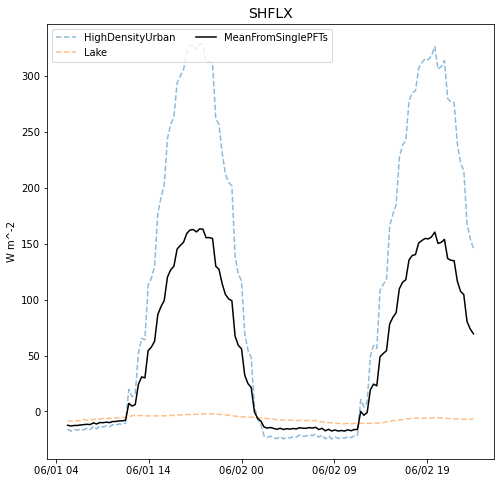

In [13]:
# Format for time on x-axis
myFmt = mdates.DateFormatter('%m/%d %H')

fig, axs0 = plt.subplots(1,1, figsize=(8, 8))

for iSfc in range(len(camDS_indivdSfc5050_keepVars.sfcType.values)):
    axs0.plot(times,np.squeeze(camDS_indivdSfc5050_keepVars.SHFLX.values[iSfc,:,:,:]),'--',alpha=0.5,label=camDS_indivdSfc5050_keepVars.sfcType.values[iSfc])
axs0.plot(times, np.squeeze(newDS_indivdSfc5050_fullWgt.SHFLX.values),'k',label='MeanFromSinglePFTs')
axs0.legend(ncol=2,loc='upper left')
axs0.set_title('SHFLX',fontsize=14)
axs0.set_ylabel('W m^-2')
# axs[0].set_ylim([-50,275])
axs0.xaxis.set_major_formatter(myFmt)
axs0.xaxis.set_major_locator(plt.MaxNLocator(5))


Text(0.5, 0, 'Time (UTC: mm/dd hh)')

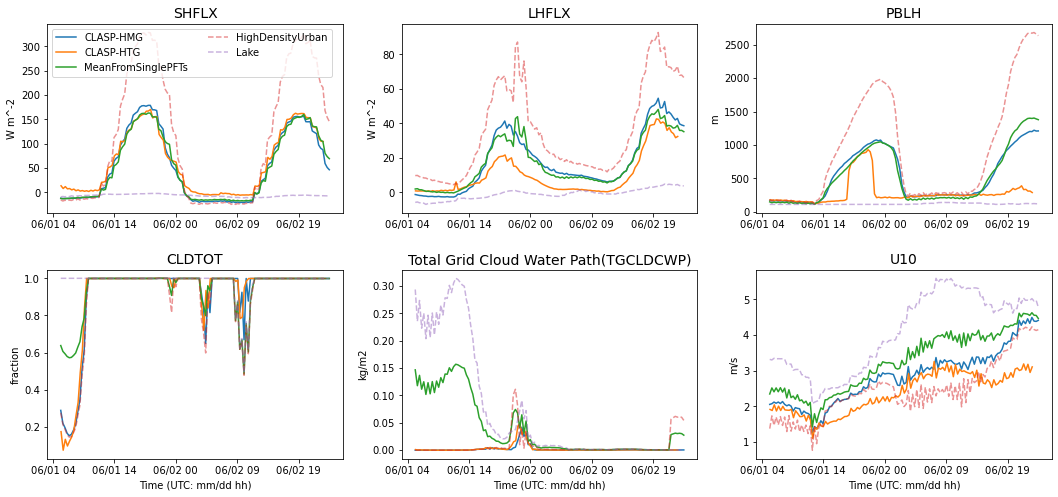

In [14]:
# Format for time on x-axis
myFmt = mdates.DateFormatter('%m/%d %H')

fig, axs = plt.subplots(2,3, figsize=(18, 8))
axs      = axs.ravel()
fig.subplots_adjust(hspace=0.3)

axs[0].plot(times, np.squeeze(camDS_5050hmg.SHFLX.values),label='CLASP-HMG')
axs[0].plot(timesHTG, np.squeeze(camDS_5050htg.SHFLX.values),label='CLASP-HTG')
axs[0].plot(times, np.squeeze(newDS_indivdSfc5050_fullWgt.SHFLX.values),label='MeanFromSinglePFTs')
for iSfc in range(len(camDS_indivdSfc5050_keepVars.sfcType.values)):
    axs[0].plot(times,np.squeeze(camDS_indivdSfc5050_keepVars.SHFLX.values[iSfc,:,:,:]),'--',alpha=0.5,label=camDS_indivdSfc5050_keepVars.sfcType.values[iSfc])
axs[0].legend(ncol=2,loc='upper left')
axs[0].set_title('SHFLX',fontsize=14)
axs[0].set_ylabel('W m^-2')
# axs[0].set_ylim([-50,275])
axs[0].xaxis.set_major_formatter(myFmt)
axs[0].xaxis.set_major_locator(plt.MaxNLocator(5))

axs[1].plot(times, np.squeeze(camDS_5050hmg.LHFLX.values),label='CLASP-HMG')
axs[1].plot(timesHTG, np.squeeze(camDS_5050htg.LHFLX.values),label='CLASP-HTG')
axs[1].plot(times, np.squeeze(newDS_indivdSfc5050_fullWgt.LHFLX.values),label='MeanFromSinglePFTs')
for iSfc in range(len(camDS_indivdSfc5050_keepVars.sfcType.values)):
    axs[1].plot(times,np.squeeze(camDS_indivdSfc5050_keepVars.LHFLX.values[iSfc,:,:,:]),'--',alpha=0.5,label=camDS_indivdSfc5050_keepVars.sfcType.values[iSfc])
axs[1].set_title('LHFLX',fontsize=14)
axs[1].set_ylabel('W m^-2')
axs[1].xaxis.set_major_formatter(myFmt)
axs[1].xaxis.set_major_locator(plt.MaxNLocator(5))

axs[2].plot(times, np.squeeze(camDS_5050hmg.PBLH.values),label='CLASP-HMG')
axs[2].plot(timesHTG, np.squeeze(camDS_5050htg.PBLH.values),label='CLASP-HTG')
axs[2].plot(times, np.squeeze(newDS_indivdSfc5050_fullWgt.PBLH.values),label='MeanFromSinglePFTs')
for iSfc in range(len(camDS_indivdSfc5050_keepVars.sfcType.values)):
    axs[2].plot(times,np.squeeze(camDS_indivdSfc5050_keepVars.PBLH.values[iSfc,:,:,:]),'--',alpha=0.5,label=camDS_indivdSfc5050_keepVars.sfcType.values[iSfc])
axs[2].set_title('PBLH',fontsize=14)
axs[2].set_ylabel('m')
axs[2].xaxis.set_major_formatter(myFmt)
axs[2].xaxis.set_major_locator(plt.MaxNLocator(5))

axs[3].plot(times, np.squeeze(camDS_5050hmg.CLDTOT.values),label='CLASP-HMG')
axs[3].plot(timesHTG, np.squeeze(camDS_5050htg.CLDTOT.values),label='CLASP-HTG')
axs[3].plot(times, np.squeeze(newDS_indivdSfc5050_fullWgt.CLDTOT.values),label='MeanFromSinglePFTs')
for iSfc in range(len(camDS_indivdSfc5050_keepVars.sfcType.values)):
    axs[3].plot(times,np.squeeze(camDS_indivdSfc5050_keepVars.CLDTOT.values[iSfc,:,:,:]),'--',alpha=0.5,label=camDS_indivdSfc5050_keepVars.sfcType.values[iSfc])
axs[3].set_title('CLDTOT',fontsize=14)
axs[3].set_ylabel('fraction')
axs[3].xaxis.set_major_formatter(myFmt)
axs[3].xaxis.set_major_locator(plt.MaxNLocator(5))
axs[3].set_xlabel('Time (UTC: mm/dd hh)')
#axs[3].set_ylim([0.5,1.1])

axs[4].plot(times, np.squeeze(camDS_5050hmg.TGCLDCWP.values),label='CLASP-HMG')
axs[4].plot(timesHTG, np.squeeze(camDS_5050htg.TGCLDCWP.values),label='CLASP-HTG')
axs[4].plot(times, np.squeeze(newDS_indivdSfc5050_fullWgt.TGCLDCWP.values),label='MeanFromSinglePFTs')
for iSfc in range(len(camDS_indivdSfc5050_keepVars.sfcType.values)):
    axs[4].plot(times,np.squeeze(camDS_indivdSfc5050_keepVars.TGCLDCWP.values[iSfc,:,:,:]),'--',alpha=0.5,label=camDS_indivdSfc5050_keepVars.sfcType.values[iSfc])
axs[4].set_title('Total Grid Cloud Water Path(TGCLDCWP)',fontsize=14)
axs[4].set_ylabel('kg/m2')
axs[4].xaxis.set_major_formatter(myFmt)
axs[4].xaxis.set_major_locator(plt.MaxNLocator(5))
axs[4].set_xlabel('Time (UTC: mm/dd hh)')

axs[5].plot(times, np.squeeze(camDS_5050hmg.U10.values),label='CLASP-HMG')
axs[5].plot(timesHTG, np.squeeze(camDS_5050htg.U10.values),label='CLASP-HTG')
axs[5].plot(times, np.squeeze(newDS_indivdSfc5050_fullWgt.U10.values),label='MeanFromSinglePFTs')
for iSfc in range(len(camDS_indivdSfc5050_keepVars.sfcType.values)):
    axs[5].plot(times,np.squeeze(camDS_indivdSfc5050_keepVars.U10.values[iSfc,:,:,:]),'--',alpha=0.5,label=camDS_indivdSfc5050_keepVars.sfcType.values[iSfc])
axs[5].set_title('U10',fontsize=14)
axs[5].set_ylabel('m/s')
axs[5].xaxis.set_major_formatter(myFmt)
axs[5].xaxis.set_major_locator(plt.MaxNLocator(5))
axs[5].set_xlabel('Time (UTC: mm/dd hh)')


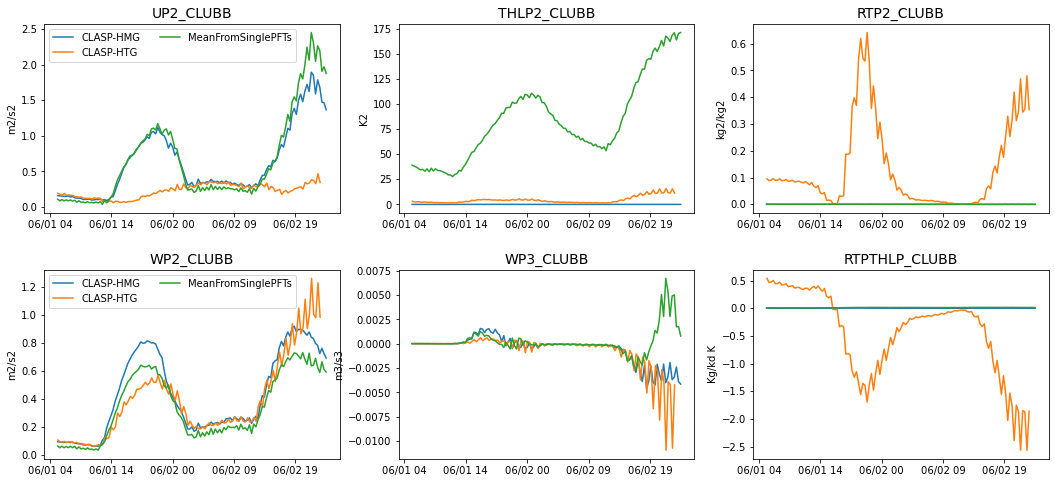

In [15]:
# Format for time on x-axis
myFmt = mdates.DateFormatter('%m/%d %H')

fig, axs = plt.subplots(2,3, figsize=(18, 8))
axs      = axs.ravel()
fig.subplots_adjust(hspace=0.3)

axs[0].plot(times, np.squeeze(newDS_CLASP_5050hmg.UP2_CLUBB_interp.values)[:,-1],label='CLASP-HMG')
axs[0].plot(timesHTG, np.squeeze(newDS_CLASP_5050htg.UP2_CLUBB_interp.values)[:,-1],label='CLASP-HTG')
axs[0].plot(times, np.squeeze(newDS_indivdSfc5050_fullWgt.UP2_CLUBB_interp.values)[:,-1],label='MeanFromSinglePFTs')
axs[0].legend(ncol=2,loc='upper left')
axs[0].set_title('UP2_CLUBB',fontsize=14)
axs[0].set_ylabel('m2/s2')
axs[0].xaxis.set_major_formatter(myFmt)
axs[0].xaxis.set_major_locator(plt.MaxNLocator(5))

axs[1].plot(times, np.squeeze(newDS_CLASP_5050hmg.THLP2_CLUBB_interp.values)[:,-1],label='CLASP-HMG')
axs[1].plot(timesHTG, np.squeeze(newDS_CLASP_5050htg.THLP2_CLUBB_interp.values)[:,-1],label='CLASP-HTG')
axs[1].plot(times, np.squeeze(thlp2_sfc5050_withHTG)[:,-1],label='MeanFromSinglePFTs')
axs[1].set_title('THLP2_CLUBB',fontsize=14)
axs[1].set_ylabel('K2')
axs[1].xaxis.set_major_formatter(myFmt)
axs[1].xaxis.set_major_locator(plt.MaxNLocator(5))

axs[2].plot(times, np.squeeze(newDS_CLASP_5050hmg.RTP2_CLUBB_interp.values)[:,-1],label='CLASP-HMG')
axs[2].plot(timesHTG, np.squeeze(newDS_CLASP_5050htg.RTP2_CLUBB_interp.values)[:,-1],label='CLASP-HTG')
axs[2].plot(times, np.squeeze(rtp2_sfc5050_withHTG)[:,-1],label='MeanFromSinglePFTs')
axs[2].set_title('RTP2_CLUBB',fontsize=14)
axs[2].set_ylabel('kg2/kg2')
axs[2].xaxis.set_major_formatter(myFmt)
axs[2].xaxis.set_major_locator(plt.MaxNLocator(5))

axs[3].plot(times, np.squeeze(newDS_CLASP_5050hmg.WP2_CLUBB_interp.values)[:,-1],label='CLASP-HMG')
axs[3].plot(timesHTG, np.squeeze(newDS_CLASP_5050htg.WP2_CLUBB_interp.values)[:,-1],label='CLASP-HTG')
axs[3].plot(times, np.squeeze(newDS_indivdSfc5050_fullWgt.WP2_CLUBB_interp.values)[:,-1],label='MeanFromSinglePFTs')
axs[3].legend(ncol=2,loc='upper left')
axs[3].set_title('WP2_CLUBB',fontsize=14)
axs[3].set_ylabel('m2/s2')
axs[3].xaxis.set_major_formatter(myFmt)
axs[3].xaxis.set_major_locator(plt.MaxNLocator(5))

axs[4].plot(times, np.squeeze(newDS_CLASP_5050hmg.WP3_CLUBB_interp.values)[:,-1],label='CLASP-HMG')
axs[4].plot(timesHTG, np.squeeze(newDS_CLASP_5050htg.WP3_CLUBB_interp.values)[:,-1],label='CLASP-HTG')
axs[4].plot(times, np.squeeze(newDS_indivdSfc5050_fullWgt.WP3_CLUBB_interp.values)[:,-1],label='MeanFromSinglePFTs')
axs[4].set_title('WP3_CLUBB',fontsize=14)
axs[4].set_ylabel('m3/s3')
axs[4].xaxis.set_major_formatter(myFmt)
axs[4].xaxis.set_major_locator(plt.MaxNLocator(5))

axs[5].plot(times, np.squeeze(newDS_CLASP_5050hmg.RTPTHLP_CLUBB_interp.values)[:,-1],label='CLASP-HMG')
axs[5].plot(timesHTG, np.squeeze(newDS_CLASP_5050htg.RTPTHLP_CLUBB_interp.values)[:,-1],label='CLASP-HTG')
axs[5].plot(times, np.squeeze(thlpRtp_sfc5050_withHTG)[:,-1],label='MeanFromSinglePFTs')
axs[5].set_title('RTPTHLP_CLUBB',fontsize=14)
axs[5].set_ylabel('Kg/kd K')
axs[5].xaxis.set_major_formatter(myFmt)
axs[5].xaxis.set_major_locator(plt.MaxNLocator(5))


In [ ]:
axs[0].plot(times, np.squeeze(newDS_CLASP_5050hmg.UP2_CLUBB_interp.values)[:,-1],label='CLASP-HMG')
axs[0].plot(timesHTG, np.squeeze(newDS_CLASP_5050htg.UP2_CLUBB_interp.values)[:,-1],label='CLASP-HTG')
axs[0].plot(times, np.squeeze(newDS_indivdSfc5050_fullWgt.UP2_CLUBB_interp.values)[:,-1],label='MeanFromSinglePFTs')
axs[0].legend(ncol=2,loc='upper left')
axs[0].set_title('UP2_CLUBB',fontsize=14)
axs[0].set_ylabel('m2/s2')
axs[0].xaxis.set_major_formatter(myFmt)
axs[0].xaxis.set_major_locator(plt.MaxNLocator(5))

In [59]:
newDS_indivdSfc5050_keepVars.THLP2_CLUBB_interp

<xarray.DataArray 'THLP2_CLUBB_interp' (sfcType: 2, time: 127, interpLevs: 29)>
array([[[ 0.00011287,  0.00011493,  0.00011608, ...,  0.00251183,
          0.00611545,  0.00328632],
        [ 0.00011271,  0.00011463,  0.00011563, ...,  0.00210733,
          0.00550719,  0.00347692],
        [ 0.00011273,  0.00011455,  0.00011544, ...,  0.00259221,
          0.00623338,  0.00327607],
        ...,
        [ 0.00762409,  0.01065542,  0.01337006, ...,  0.05144411,
          0.05557663,  0.01359414],
        [ 0.00787514,  0.01084592,  0.01312801, ...,  0.0419472 ,
          0.03545239,  0.00299712],
        [ 0.00691749,  0.00949195,  0.01172151, ...,  0.03323902,
          0.02625859,  0.00121234]],

       [[ 0.00011089,  0.00011265,  0.00011367, ...,  0.01449873,
          0.01177127,  0.00509922],
        [ 0.00011279,  0.00011473,  0.000116  , ...,  0.0024817 ,
          0.00516816,  0.00445134],
        [ 0.00011275,  0.00011456,  0.00011551, ...,  0.01257944,
          0.00823383,  0.00412039],
        ...,
        [ 0.00013067,  0.000123  ,  0.0001186 , ...,  0.00332702,
          0.0042432 , -0.00121541],
        [ 0.00012999,  0.0001218 ,  0.00011835, ...,  0.00388778,
          0.00297953, -0.00241216],
        [ 0.00012893,  0.00012216,  0.00011925, ...,  0.00398995,
          0.00262237, -0.00271905]]])
Coordinates:
  * time        (time) datetime64[ns] 2015-06-01T06:00:00 ... 2015-06-03
  * sfcType     (sfcType) <U16 'HighDensityUrban' 'Lake'
  * interpLevs  (interpLevs) float64 700.0 710.0 720.0 ... 960.0 970.0 980.0

Text(0.5, 1.0, 'THLP2_CLUBB')

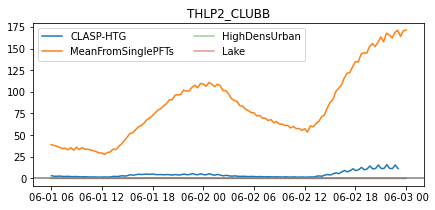

In [117]:
fig, axs0 = plt.subplots(1,1, figsize=(7, 3))

axs0.plot(timesHTG, np.squeeze(newDS_CLASP_5050htg.THLP2_CLUBB_interp.values)[:,-1], label='CLASP-HTG')
# axs0.plot(times, np.squeeze(clmDS_5050hmg.ZETA.values), label='CLASP-HMG')
axs0.plot(times, np.squeeze(thlp2_sfc5050_withHTG)[:,-1], label='MeanFromSinglePFTs')

axs0.plot(times, np.squeeze(newDS_indivdSfc5050_keepVars.THLP2_CLUBB_interp.values)[0,:,-1], label='HighDensUrban',alpha=0.5)
axs0.plot(times, np.squeeze(newDS_indivdSfc5050_keepVars.THLP2_CLUBB_interp.values)[1,:,-1], label='Lake',alpha=0.5)
axs0.legend(ncol=2)

axs0.axhline(0,color='gray')
axs0.set_title('THLP2_CLUBB')



Text(0.5, 1.0, 'ZETA')

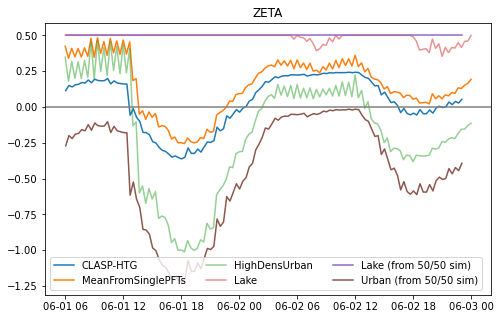

In [115]:
fig, axs0 = plt.subplots(1,1, figsize=(8, 5))

axs0.plot(timesHTG, np.squeeze(clmDS_5050htg.ZETA.values), label='CLASP-HTG')
# axs0.plot(times, np.squeeze(clmDS_5050hmg.ZETA.values), label='CLASP-HMG')
axs0.plot(times, np.squeeze(clmDS_indivdSfc5050_fullWeighted.ZETA.values), label='MeanFromSinglePFTs')

axs0.plot(times, np.squeeze(clmDS_indivdSfc5050.ZETA.values)[0,:], label='HighDensUrban',alpha=0.5)
axs0.plot(times, np.squeeze(clmDS_indivdSfc5050.ZETA.values)[1,:], label='Lake',alpha=0.5)

axs0.plot(timesHTG, zeta_htg_lake, label='Lake (from 50/50 sim)')
axs0.plot(timesHTG, zeta_htg_urban, label='Urban (from 50/50 sim)')

axs0.legend(ncol=3)

axs0.axhline(0,color='gray')
axs0.set_title('ZETA')




Text(0.5, 1.0, 'USTAR')

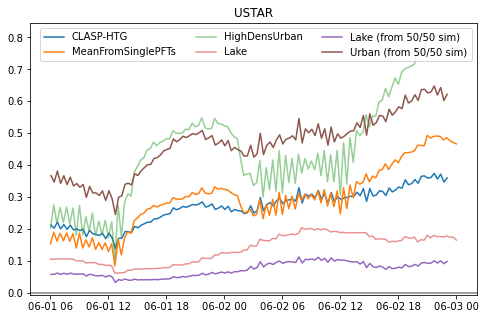

In [116]:
fig, axs0 = plt.subplots(1,1, figsize=(8, 5))

axs0.plot(timesHTG, np.squeeze(clmDS_5050htg.USTAR.values), label='CLASP-HTG')
# axs0.plot(times, np.squeeze(clmDS_5050hmg.USTAR.values), label='CLASP-HMG')
axs0.plot(times, np.squeeze(clmDS_indivdSfc5050_fullWeighted.USTAR.values), label='MeanFromSinglePFTs')

axs0.plot(times, np.squeeze(clmDS_indivdSfc5050.USTAR.values)[0,:], label='HighDensUrban',alpha=0.5)
axs0.plot(times, np.squeeze(clmDS_indivdSfc5050.USTAR.values)[1,:], label='Lake',alpha=0.5)

axs0.plot(timesHTG, ustar_htg_lake, label='Lake (from 50/50 sim)')
axs0.plot(timesHTG, ustar_htg_urban, label='Urban (from 50/50 sim)')

axs0.legend(ncol=3)

axs0.axhline(0,color='gray')

axs0.set_title('USTAR')
